<a href="https://colab.research.google.com/github/modellatore/Codes/blob/main/ODE_solving_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian
!pip install torchdiffeq
from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def lagrangian(x, g=9.81, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)               #kinetic energy
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2   #potential energy 
    return T - V 

def E(x, g=9.81, k=10):
    try:
        q, qt = torch.split(x, 2)
        cos = torch.cos
    except: 
        q, qt = np.split(x, 2)
        cos = np.cos
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
    return T + V 

In [ ]:
def get_qdtt(q, qt, g=9.81, k=10):                                                #given generalized coord & vel it gives back accelerations
    '''
    q is array of generalised coords, [r, theta]  
    qt is array of generalised velocities, [rdt, thetadt]
    qdtt is array of accelerations, [rddt, thetaddt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    '''
    We apply the Euler-Lagrange equations for both coordinates
    '''

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1)  # acceleration of r 
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]              # acceleration of theta 

    return qdtt  

def get_xt_anal(x, t):
    d = np.zeros_like(x)
    d[:, :2] = x[:, 2:]                           #take last 2 coloumns of x and put them in the first 2 of d 
    d[:, 2:] = get_qdtt(x[:, :2], x[:, 2:])       #compute the accelerations of first 2 coloumns of x and last 2 coloumns of x 

    #print(x, d)
    return d

def anal_solve_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_anal(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(get_qdtt(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))

        #print(x, d)
        return d
    
    return odeint(f_anal, x0, t, rtol=1e-10, atol=1e-10)
    
def q2xy(ql):
    '''
    Polar coords to xy 
    '''
    try: 
        xy = np.zeros_like(ql)
        sin = np.sin
        cos = np.cos
    except: 
        xy = torch.zeros_like(ql)
        sin = torch.sin
        cos = torch.cos

    xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
    return xy  

In [ ]:
def get_xt(lagrangian, t, x):      #Vectorial version of the Euler-Lagrange eqns
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, 2, dim=0)

    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]

    tqtt = A @ (B - C @ tqt)

    xt = torch.cat([tqt, torch.squeeze(tqtt)]) #vel & accel

    return xt

def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_xt, lagrangian)  #accelerations already present in the function
    return tor_odeint(f, x0, t)

In [ ]:
def rk4_step(f, x, t, h):
    # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [ ]:
t_train = torch.tensor(np.linspace(0, 10, 1000)).float()
tstep = t_train[1].item() 
q0 = np.array([0.8, 0.3])
qt0 = np.array([0.0, 0.0])             #still object

x_train = torch.tensor(anal_solve_ode(q0, qt0, t_train))              #gets the positions and the velocities of the lenght & angle of the pendulum (4 entries)
y_train = torch.tensor(rk4_step(get_xt_anal, x_train, t_train, tstep))

Ex = [E(x) for x in x_train]
Ey = [E(x) for x in y_train]
x_train = q2xy(x_train)
y_train = q2xy(y_train)

Ex = np.array(Ex)
Ey = np.array(Ey)
Ex.mean(), Ey.mean()

tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)]) #initial pos & vel
tpath = torch_solve_ode(tx0, t_train, lagrangian)
Et = [E(x) for x in tpath]
tpath = q2xy(tpath)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


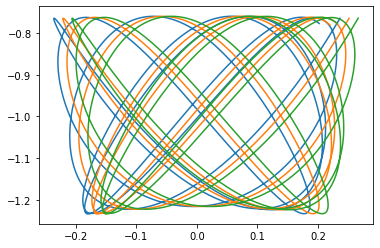

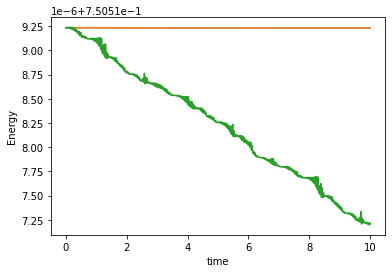

In [ ]:
with torch.no_grad():

  plt.plot(x_train[:, 0], x_train[:, 1])
  plt.plot(y_train[:, 0]+0.015, y_train[:, 1])
  plt.plot(tpath[:, 0]+0.03, tpath[:, 1])
  plt.show()

  plt.plot(t_train, Ey, label='float')
  plt.plot(t_train, Ex, label='NON float')
  plt.plot(t_train, Et, label='torch solved')
  plt.xlabel('time')
  plt.ylabel('Energy')
  plt.show()


